# How to Work with Million-row Datasets Like a Pro
## It is time to take off your training wheels
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@belart84?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Artem Beliaikin</a>
        on 
        <a href='https://www.pexels.com/photo/aerial-photo-of-woman-standing-in-flower-field-1657974/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels.</a> All images are by the author unless specified otherwise.
    </strong>
</figcaption>

# Setup

In [14]:
import logging
import time

import catboost as cb
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Introduction

One of the difficult stages of my learning journey was about overcoming my fear of massive datasets. It wasn't easy because working with million-row datasets was nothing like the tiny, toy datasets that the online courses continuously gave me. 

Today, I am here to share with you the concepts and tricks I have learned to handle the challenges of gigabyte-sized datasets with millions, or even billions of rows. By the end, they will feel to you almost as natural as importing the Iris or Titanic.

# Read in the massive dataset

The first obstacle you will encounter is reading the dataset into your working environment, specifically the time it takes to load them (TODO). At this stage, don't use pandas - there are much faster alternatives available. One of my favorites is the `datatable` package which can read data up to 10 times faster than pandas. 

As an example, we will load ~1M row Kaggle TPS September 2021 dataset with both `datatable` and `pandas` and compare the speeds:

In [1]:
import datatable as dt  # pip install datatable
import pandas as pd

In [2]:
%%time
tps_dt = dt.fread("data/tps_september_train.csv").to_pandas()
tps_dt.head()

Wall time: 5.67 s


,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,True
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,False
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,True
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,True
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,True


In [3]:
%%time
tps_df = pd.read_csv("data/tps_september_train.csv")
tps_df.head()

Wall time: 23.2 s


,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


7 times speed up! The `datatable` API for manipulating data may not be as intuitive as `pandas` - so, call the `to_pandas` method after reading the data to convert it to a DataFrame.

Apart from `datatable`, there are `Dask`, `Vaex`, or `cuDF`, etc. that read data multiple times faster than pandas. If you want to see some of those in action, refer to [this notebook](https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets) on reading large datasets by a Kaggle Grandmaster Rohan Rao.

# Reduce the memory size

Next, we have the memory issues. Even a 200k row datasets may exhaust your 16GB RAM while doing complex computations.

I have experienced this first-hand *twice* in the last month's TPS competition on Kaggle. First one was when projecting the training data to 2D using UMAP - I ran out of RAM. The second was while computing the SHAP values with XGBoost for the test set - I ran out of GPU VRAM. What is shocking is that the training and test sets only had 250k and 150k rows with a hundred features and I was using Kaggle kernels. 

The dataset we are using today has ~960k rows with 120 features, so memory issues are much more likely:

In [4]:
memory_usage = tps_df.memory_usage(deep=True) / 1024 ** 2

memory_usage.head(7)

Index    0.000122
id       7.308342
f1       7.308342
f2       7.308342
f3       7.308342
f4       7.308342
f5       7.308342
dtype: float64

In [5]:
memory_usage.sum()

877.0011596679688

Using the `memory_usage` method on a DataFrame with `deep=True`, we can get the exact estimate of how much RAM each feature is consuming - 7 MBs. Overall, it is close to 1GB.

Now, there are certain tricks you can use to decrease memory usage up to 90%. These tricks have a lot to do with changing the data type of each feature to the smallest subtype as possible. 

Python represents various data with unique data types such as `int`, `float`, `str`, etc. In contrast, pandas has several NumPy alternatives for each of Python's data types:

![](https://miro.medium.com/max/1050/1*j9CH_6m1XrvuPz2DUGf5tQ.png)
<figcaption style="text-align: center;">
    <strong>
        Source: http://pbpython.com/pandas_dtypes.html
    </strong>
</figcaption>

Numbers next to the datatype refers to how many bits of memory a single unit of data consumes when represented in that format. To reduce the memory as much as possible, choose the smallest NumPy data format you can assign to the data. Here is a handy table to understand this:

![](https://miro.medium.com/max/1050/1*f7kTFcscHI7dstMHZ1_eFg.png)
<figcaption style="text-align: center;">
    <strong>
        Source: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html
    </strong>
</figcaption>

In the above table, `uint` refers to unsigned, only positive integers. I have found this handy function that reduces the memory of pandas DataFrames based on the above table (shout out to [this Kaggle kernel](https://www.kaggle.com/somang1418/tuning-hyperparameters-under-10-minutes-lgbm?scriptVersionId=11067143&cellId=10)):

In [6]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

Based on the minimum and maximum value of a *numeric* column and the above table, the function converts it to the smallest subtype possible to reduce as much memory as possible. Let's use it on our data:

In [7]:
reduced_df = reduce_memory_usage(tps_df, verbose=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mem. usage decreased to 262.19 Mb (70.1% reduction)


70% memory reduction is pretty impressive. However, please note that memory reduction won't speed up computation in most cases. If memory size is not an issue, you can skip this step.

Regarding non-numeric data types, never use the `object` datatype in Pandas as it consumes the most memory. Either use `str` or `category` if there are few unique values in the feature. In fact, using `pd.Categorical` data type can speed things up to 10 times while using LGBM's default categorical handler.

For other data types like `datetime` or `timedelta`, use the native formats offered in `pandas` since they enable special manipulation functions.

# Choose a data manipulation library

Up until this point, I mainly mentioned `pandas` as a data manipulation library. It might be slow but the vast range of data manipulation functions give it a mounting advantage over its competitors. 

But what can its competitors do? Let's start with `datatable` (again).

[`datatable`](https://datatable.readthedocs.io/en/latest/start/index-start.html) allows multi-threaded preprocssing of datasets sized up to 100 GBs. At such scales, `pandas` starts throwing memory errors while `datatable` humbly executes. You can read [this excellent article](https://towardsdatascience.com/an-overview-of-pythons-datatable-package-5d3a97394ee9) by @parulpandey for an intro to the package.

Another alternative is [`cuDF`](https://docs.rapids.ai/api/cudf/stable/), developed by RAPIDS. This package has many dependencies and should only be used in extreme cases (think hundreds of billions). It enables running preprocessing functions distributed over one or more GPUs as is the requirement by most of today's data applications. Unlike `datatable`, its API is very similar to `pandas`. Read [this article](https://developer.nvidia.com/blog/pandas-dataframe-tutorial-beginners-guide-to-gpu-accelerated-dataframes-in-python/) from the NVIDIA blog for more information.

You can also check out [Dask](https://dask.org/) or [Vaex](https://vaex.io/docs/index.html) that offer similar functionalities.

If you are dead set on `pandas`, then read on to the next section.

# Sample the data

Regardless of any speed tricks or packages on GPU steroids, too much data, well, is too much. When you have millions of samples, there is a good chance you can sample it in a way that all feature distributions are preserved. 

This is done mainly to speed up computation. Instead of running experiments, feature engineering and training baseline models on all the data, take a small sample. Typically, 10-20% is enough. Here is how it is done in pandas:

In [9]:
sample_df = tps_df.sample(int(len(tps_df) * 0.2))
sample_df.shape

(191583, 120)

As a proof, we can plot a histogram of a single feature from both the sample and the original data:

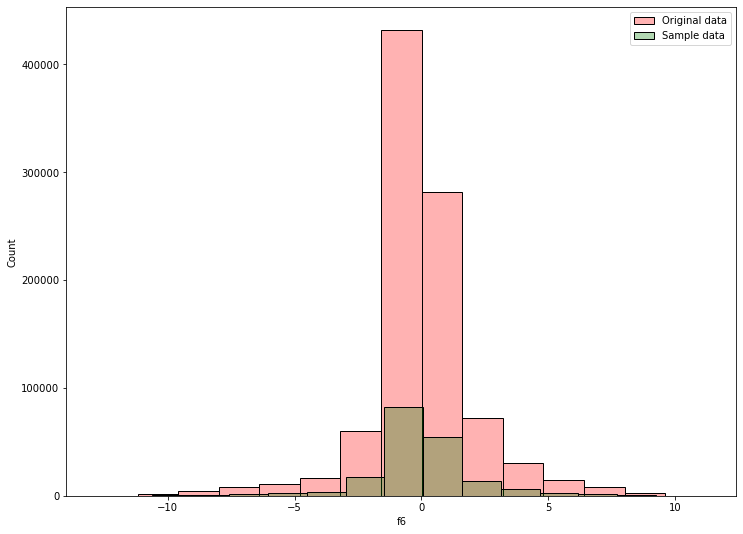

In [31]:
fig, ax = plt.subplots(figsize=(12, 9))

sns.histplot(
    data=tps_df, x="f6", label="Original data", color="red", alpha=0.3, bins=15
)
sns.histplot(
    data=sample_df, x="f6", label="Sample data", color="green", alpha=0.3, bins=15
)

plt.legend()
plt.show();

As you can see, the distributions are roughly the same - you can even compare the variances. 

Now, you can use this sample for rapid prototyping, experimenting, building model validation strategy, etc.

# Use vectorization instead of loops

Whenever you find yourself itching to use some type of looping function like `apply`, `applymap`, or `itertuples` - just stop. Use vectorization instead.

First, start thinking about DataFrame columns as giant n-dimensional vectors. As you know, vector operations affect each element in the vector simultaneously removing the need for loops in math. Vectorization is the process of executing operations on arrays, rather than individual scalars.

Pandas has a large collection of vectorized functions. In fact, virtually any function and operator with the ability to affect each element in the array is vectorized in pandas. These functions are orders of magnitude faster than anything that loops.

You can also define custom vectorized preprocessing functions that accept whole DataFrame columns as vectors rather than scalars. The hairy details of this is beyond the scope of this article. Why don't you check out [this awesome guide](https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6)?